# Turning Neuromorphic Dynex Chips into Torch Layers

In [47]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch.optim import Adam

## Import dnx layer classes

In [4]:
from HybridQRBM.pytorchdnx import dnx
from HybridQRBM.optimizers import RBMOptimizer
from HybridQRBM.samplers import DynexSampler

## Parameters

In [8]:
# define training hyperparameters
INIT_LR    = 1e-3
BATCH_SIZE = 12000 #64
EPOCHS     = 10
device = "cpu" # no GPU used for Dynex only

## Define Model

In [36]:
optimizer = RBMOptimizer(
                learning_rate=0.05,
                momentum=0.9,
                decay_factor=1.00005,
                regularizers=()
            );

sampler = DynexSampler(mainnet=False, 
               num_reads=100, 
               annealing_time=1000, 
               debugging=False, 
               logging=False, 
               num_gibbs_updates=1, 
               minimum_stepsize=0.002);

In [37]:
class QModel(nn.Module):
    def __init__(self, n_hidden, sampler, optimizer):
        super().__init__();
        # Dynex Neuromporphic layer
        self.dnxlayer = dnx(n_hidden, sampler=sampler, optimizer=optimizer); 

    def forward(self, x):
        x = self.dnxlayer(x);
        return x;

## Load Data

In [38]:
# conversion function from grayscale to black & white
from torchvision import transforms
class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255.  # input threshold for [0..255] gray level, convert to [0..1]

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type

data_transformer = transforms.Compose([
        #transforms.Grayscale(),
        transforms.ToTensor(),
        ThresholdTransform(thr_255=240)
    ])

In [39]:
# load the MNIST dataset
from torchvision.datasets import MNIST
trainData = MNIST(root="data", train=True, download=True,
	transform=data_transformer)
testData = MNIST(root="data", train=False, download=True,
	transform=data_transformer) 
print("[INFO] MNIST dataset lodaed")

[INFO] MNIST dataset lodaed


In [40]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

In [41]:
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
print(trainSteps,'train steps per epoch');

5 train steps per epoch


## Training

In [42]:
#img_dim = len(trainData.data[0]);
n_hidden = 60;
model = QModel(n_hidden, sampler, optimizer);

In [43]:
for e in range(0, EPOCHS):
	print('EPOCH',e,'of',EPOCHS);
	# set the model in training mode
	model.train()
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x);

EPOCH 0 of 10
DynexQRBM PyTorch Layer | SME: 0.249957
DynexQRBM PyTorch Layer | SME: 0.194690
DynexQRBM PyTorch Layer | SME: 0.159149
DynexQRBM PyTorch Layer | SME: 0.127481
DynexQRBM PyTorch Layer | SME: 0.101892
EPOCH 1 of 10
DynexQRBM PyTorch Layer | SME: 0.097564
DynexQRBM PyTorch Layer | SME: 0.107390
DynexQRBM PyTorch Layer | SME: 0.086634
DynexQRBM PyTorch Layer | SME: 0.072916
DynexQRBM PyTorch Layer | SME: 0.073510
EPOCH 2 of 10
DynexQRBM PyTorch Layer | SME: 0.074850
DynexQRBM PyTorch Layer | SME: 0.073972
DynexQRBM PyTorch Layer | SME: 0.072913
DynexQRBM PyTorch Layer | SME: 0.070524
DynexQRBM PyTorch Layer | SME: 0.068217
EPOCH 3 of 10
DynexQRBM PyTorch Layer | SME: 0.066364
DynexQRBM PyTorch Layer | SME: 0.065011
DynexQRBM PyTorch Layer | SME: 0.064532
DynexQRBM PyTorch Layer | SME: 0.063777
DynexQRBM PyTorch Layer | SME: 0.063184
EPOCH 4 of 10
DynexQRBM PyTorch Layer | SME: 0.062706
DynexQRBM PyTorch Layer | SME: 0.062277
DynexQRBM PyTorch Layer | SME: 0.062135
DynexQRBM 

In [45]:
#naiveModel = model.dnxlayer.errors
dnxModel = model.dnxlayer.errors

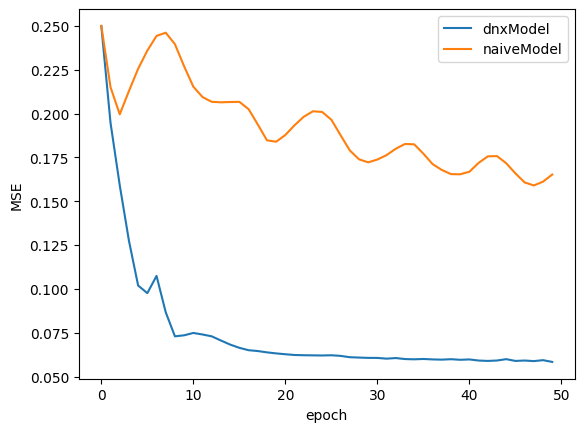

In [46]:
plt.figure()
plt.plot(dnxModel, label='dnxModel')
plt.plot(naiveModel, label='naiveModel')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()